A Predictive Analysis of Heart Disease 

We are using a data set from a Cleveland database with various measurements of variables correlated to heart disease, where 1-4 indicates presence and 0 indicates absence. Our goal is to create a predictive data frame that will allow us to take a set of unknown values and predict whether or not it could indicate the development or presence of heart disease in an individual. The question we are looking to answer is ‘given an unknown observation and several values from the table, is the person likely to develop heart disease or not?’ The data set that will be used to answer this question is the cleveland_data set; it has values for the following variables: age, sex, chest_pain, resting_bp, cholesterol, fasting_blood_sugar, resting_electro, max_hr, ex_angina, oldpeak, slope, ca, thal, num, some of which will be used to help us make our predictive data frame.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "cleveland_data")

In [3]:
heart_disease_data <- read_delim("cleveland_data", col_names = FALSE, skip=20, delim= ",")
heart_disease_data

Rows: 283 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [4]:
names(heart_disease_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fasting_blood_sugar", "resting_electro", "max_hr", "ex_angina", "oldpeak", "slope", "ca", "thal", "num")
heart_disease_data <- heart_disease_data |>
mutate(sex = case_when(sex == 1 ~ "male" , sex == 0 ~ "female"))|>
mutate(chest_pain = case_when(chest_pain == 1 ~ "typical angina", chest_pain == 2 ~ "atypical angina", chest_pain == 3 ~ "non-anginal pain", chest_pain == 4 ~ "asymptomatic"))|>
mutate(fasting_blood_sugar = case_when(fasting_blood_sugar == 1 ~ "true" , fasting_blood_sugar == 0 ~ "false"))|>
mutate(resting_electro = case_when(resting_electro == 0 ~ "normal", resting_electro == 1 ~ "abnormal", resting_electro == 2 ~ "hypertrophy"))|>
mutate(ex_angina = case_when(ex_angina == 1 ~ "yes" , ex_angina == 0 ~ "no"))|>
mutate(slope = case_when(slope == 1 ~ "upsloping", slope == 2 ~ "flat", slope == 3 ~ "downsloping"))|>
mutate(thal = case_when(thal == "3.0" ~ "normal", thal == "6.0" ~ "fixed defect", thal == "7.0" ~ "reversable defect"))|>
mutate(num = case_when(num == 0 ~ "healthy" , num == 1 ~ "sick", num == 2 ~ "sick", num == 3 ~ "sick", num == 4 ~ "sick"))
heart_disease_data$ca[heart_disease_data$ca == "?"] <- NA
heart_disease_data$thal[heart_disease_data$thal == "?"] <- NA
heart_disease_data

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
64,male,typical angina,110,211,false,hypertrophy,144,yes,1.8,flat,0.0,normal,healthy
58,female,typical angina,150,283,true,hypertrophy,162,no,1.0,upsloping,0.0,normal,healthy
58,male,atypical angina,120,284,false,hypertrophy,160,no,1.8,flat,0.0,normal,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,male,asymptomatic,130,131,false,normal,115,yes,1.2,flat,1.0,reversable defect,sick
57,female,atypical angina,130,236,false,hypertrophy,174,no,0.0,flat,1.0,normal,sick
38,male,non-anginal pain,138,175,false,normal,173,no,0.0,upsloping,NA,normal,healthy


In [5]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split) 

In [6]:
glimpse(heart_disease_train)

Rows: 212
Columns: 14
$ age                 <dbl> 64, 50, 58, 43, 69, 44, 42, 61, 71, 59, 51, 53, 41…
$ sex                 <chr> "male", "female", "female", "male", "female", "mal…
$ chest_pain          <chr> "typical angina", "non-anginal pain", "non-anginal…
$ resting_bp          <dbl> 110, 120, 120, 150, 140, 130, 140, 150, 160, 150, …
$ cholesterol         <dbl> 211, 219, 340, 247, 239, 233, 226, 243, 302, 212, …
$ fasting_blood_sugar <chr> "false", "false", "false", "false", "false", "fals…
$ resting_electro     <chr> "hypertrophy", "normal", "normal", "normal", "norm…
$ max_hr              <dbl> 144, 158, 172, 171, 151, 179, 178, 137, 162, 157, …
$ ex_angina           <chr> "yes", "no", "no", "no", "no", "yes", "no", "yes",…
$ oldpeak             <dbl> 1.8, 1.6, 0.0, 1.5, 1.8, 0.4, 0.0, 1.0, 0.4, 1.6, …
$ slope               <chr> "flat", "flat", "upsloping", "upsloping", "upslopi…
$ ca                  <chr> "0.0", "0.0", "0.0", "0.0", "2.0", "0.0", "0.0", "…
$ thal            

In [7]:
glimpse(heart_disease_test)

Rows: 71
Columns: 14
$ age                 <dbl> 58, 58, 66, 60, 59, 43, 65, 40, 65, 44, 44, 54, 51…
$ sex                 <chr> "female", "male", "female", "male", "male", "male"…
$ chest_pain          <chr> "typical angina", "non-anginal pain", "typical ang…
$ resting_bp          <dbl> 150, 132, 150, 117, 135, 120, 150, 140, 140, 112, …
$ cholesterol         <dbl> 283, 224, 226, 230, 234, 177, 225, 199, 417, 290, …
$ fasting_blood_sugar <chr> "true", "false", "false", "true", "false", "false"…
$ resting_electro     <chr> "hypertrophy", "hypertrophy", "normal", "normal", …
$ max_hr              <dbl> 162, 173, 114, 160, 161, 120, 114, 178, 157, 153, …
$ ex_angina           <chr> "no", "no", "no", "yes", "no", "yes", "no", "yes",…
$ oldpeak             <dbl> 1.0, 3.2, 2.6, 1.4, 0.5, 2.5, 1.0, 1.4, 0.8, 0.0, …
$ slope               <chr> "upsloping", "upsloping", "downsloping", "upslopin…
$ ca                  <chr> "0.0", "2.0", "0.0", "2.0", "0.0", "0.0", "3.0", "…
$ thal             

In [8]:
heart_disease_proportions <- heart_disease_train |>
                      group_by(num) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_disease_train))

heart_disease_proportions

num,n,percent
<chr>,<int>,<dbl>
healthy,113,53.30189
sick,99,46.69811


In [9]:
heart_disease_table <- heart_disease_train |>
group_by(num) |>
summarize (n = n())
heart_disease_table

num,n
<chr>,<int>
healthy,113
sick,99


In [10]:
heart_disease_table2 <- heart_disease_train |>
group_by(num)|>
summarize(resting_bp = mean(resting_bp),
          cholesterol = mean(cholesterol),
          max_hr = mean(max_hr))
heart_disease_table2

num,resting_bp,cholesterol,max_hr
<chr>,<dbl>,<dbl>,<dbl>
healthy,128.3805,239.4602,158.5664
sick,135.9091,254.3838,140.5152


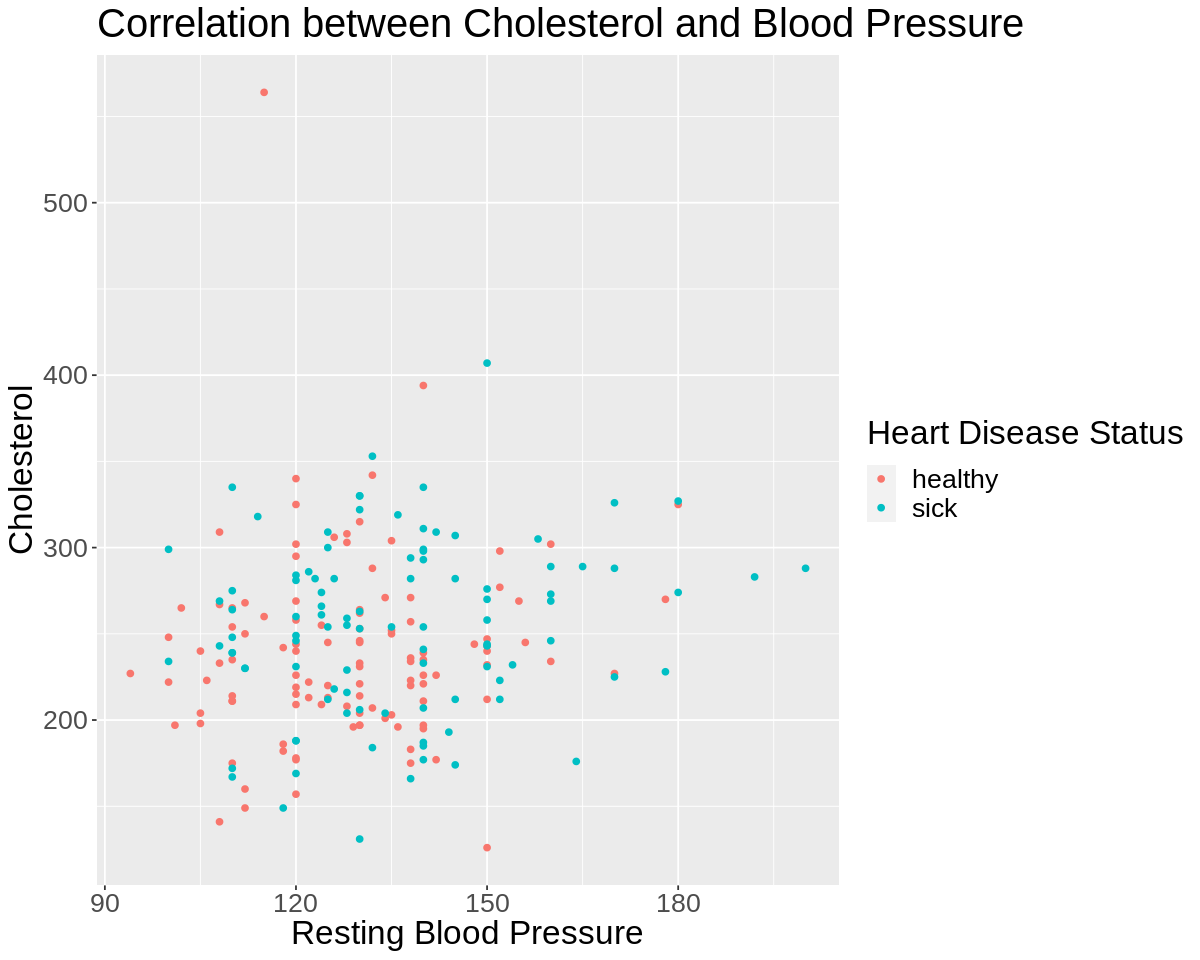

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8) 
heart_disease_plot <- heart_disease_train |>
    ggplot(aes(x = resting_bp, y = cholesterol, colour = num)) + 
        geom_point()+ 
    labs(x = "Resting Blood Pressure", y = "Cholesterol", colour = "Heart Disease Status") +
    ggtitle("Correlation between Cholesterol and Blood Pressure") +
    theme(text = element_text(size = 20))
heart_disease_plot

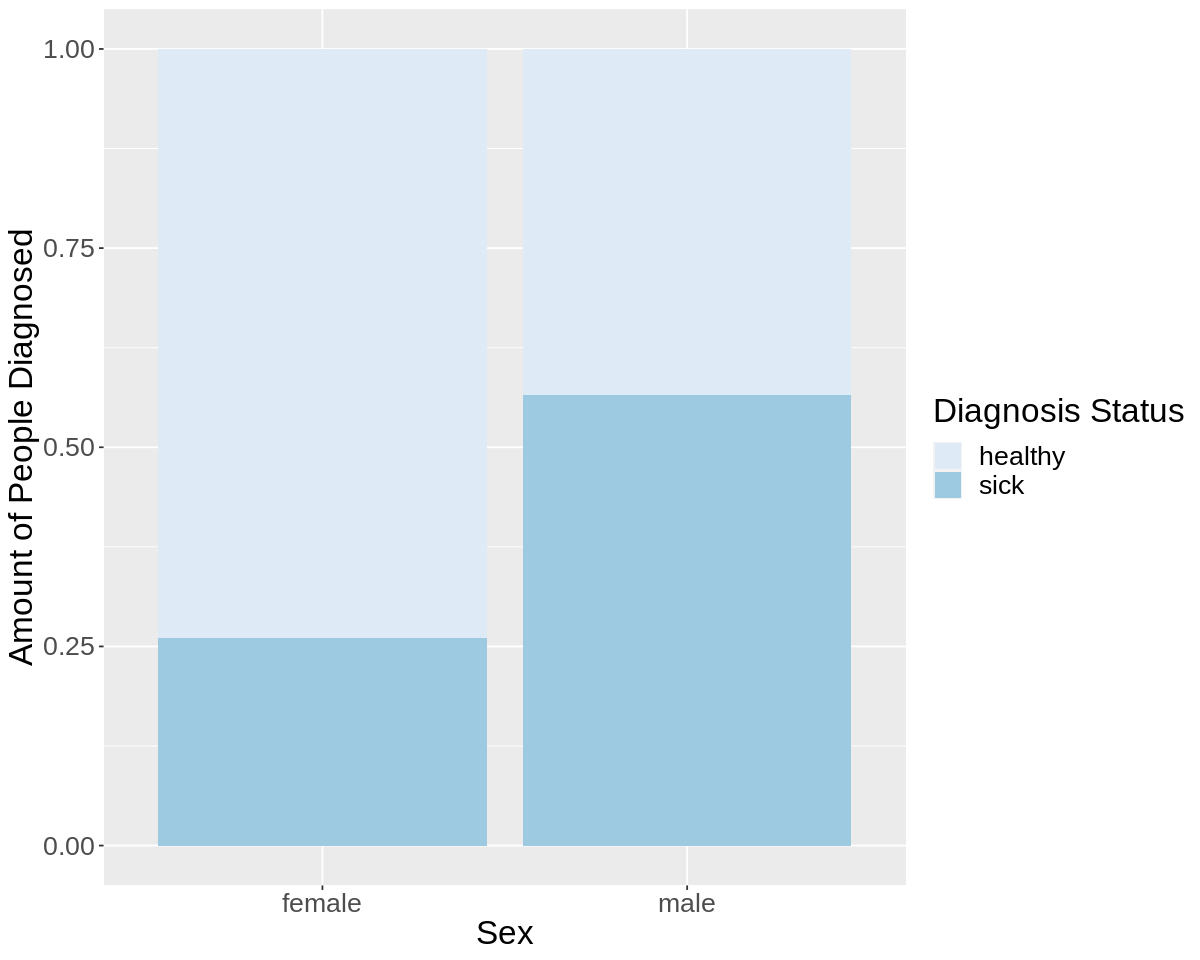

In [12]:
heart_disease_plot2 <- ggplot(heart_disease_data, aes(x = sex, fill = num)) + 
    geom_bar(position = "fill") + 
    xlab("Sex") +
    ylab("Amount of People Diagnosed") +
    labs(fill = "Diagnosis Status") +
    theme(text = element_text(size = 20)) + 
    scale_fill_brewer(palette = "Blues")
heart_disease_plot2

We will conduct the data analysis using the following variables: age, sex, chest_pain, cholesterol, max_hr, and resting_bp. We believe that these variables will have the highest value when it comes to making a predictive data frame for heart disease. Using these variables, we can hopefully find a pattern in diagnosis to help make predictions about class using tools such as k-nearest and cross-validation to increase accuracy. We plan to visualize the results in the form of a color-coded scatter plot where the points of sick and healthy individuals can be plotted such as the resting blood pressure plot and cholesterol plot that is shown. An unknown point can be added where one might be able to visually predict an answer, but use the code to produce a prediction as well.

We expect to find a few correlations between the variables that we have chosen, such as in the above visualization where males appear to be diagnosed as sick more often than females. Finding these correlations could have a great impact because many of these variables can be altered in everyday life or worked on by the average individual. This could lead individuals to strive for better lives and possibly even decrease their heart disease diagnosis by helping them be more proactive if they fall into the given frame of sickness. We think that this could lead to more questions about how predictive data frames can be used more often to give people an idea of what the likelihood of developing such a disease would be. We also believe that questions will be raised about how people choose to live their lives and how impactful their daily lifestyle choices are, as well as what contributes to increasing the likelihood of the development of these diseases even if they are predisposed.